<a href="https://colab.research.google.com/github/Kushmaniar/DevTown_Assignment/blob/main/Custom_CNN_Model_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After connecting the google drive to our colab notebook we must:
*   Download the custom Chest X-Ray Pneumonia Kaggle dataset from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
*  After downloading unzip it, you will see the chest_xray folder that contains images organized neatly into train, valid, and test subfolders. Each of these subfolders contains two sub-sub folders, one for normal chest Xrays and another for Xrays indicatingpneumonia.
* Upload the 'chest_xray' folder to the google drive, so tha we can import it into this project

The dataset directory is:
>content
>>drive
>>>MyDrive
>>>>chest_xray

In [2]:
%cd drive/MyDrive/chest_xray
%ls

[Errno 2] No such file or directory: 'drive/MyDrive/chest_xray'
/content/drive/MyDrive/chest_xray
chest_xray/  __MACOSX/  test/  train/  val/




**CONVOLUTION NEURAL NETWORKS**



What is a Convolutional Neural Network?
We have learned that Machine Learning models analyze patterns from the training data and then make predictions on the trained data.  
But for complex datatypes like audio, images, text, etc, we require deep learning models to extraxt meaningfull patterns and make predictions.


> Convolutional Neural Networks (CNNs) are one such category of deep learning models that are designed specifically for visual data like images. They use convolutional layers, pooling layers, and fully connected layers. We will understand the working of all these layers in details.
>Inspired by the human visual system, CNNs learn to recognize patterns and objects. They revolutionize computer vision tasks such as image classification and object detection.
Eg: detecting number plates of cars moving on the highway, or classifying different snacks stored in the grocery isle.









1. We will be learning how to create a Convolutional Neural Network (CNN)
2.  To make it more intuitive, we will be going through what each layer of this network does.
3.   The below  task would be to build a basic CNN that can classify images of chest Xrays and establish if it is normal or has pneumonia.







# PREPROCESSING



>**Dataset Directory Structure**



There is a standard way to lay out your image data for modeling.

After you have collected your images, you must sort them first by dataset, such as train, test, and validation, and second by their class.

For example, imagine an image classification problem where we wish to classify photos of cars based on their color, e.g. red cars, blue cars, etc.

The below image is how you should structure your data

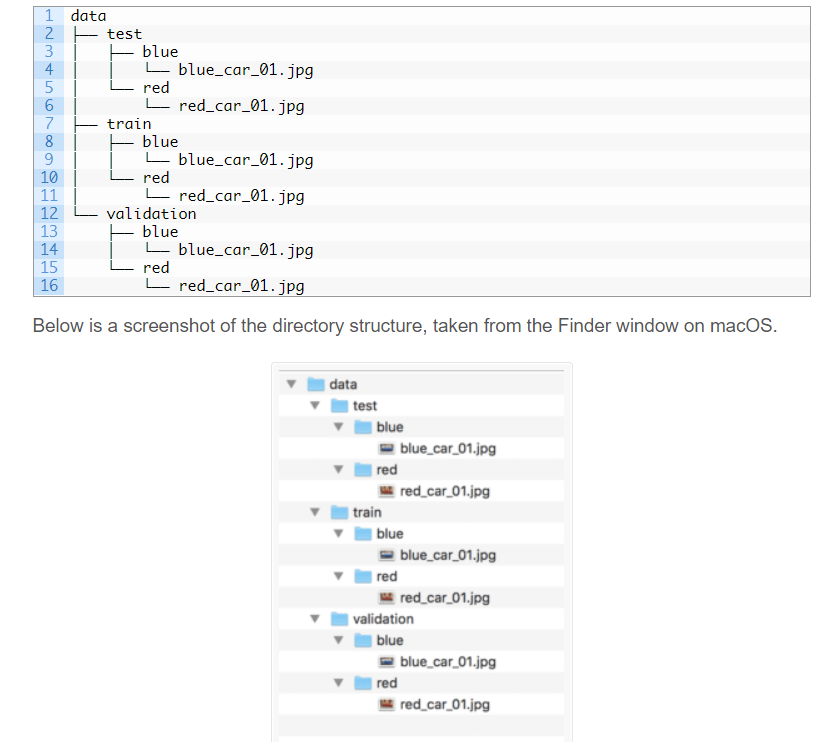



> **How to Progressively Load Images**







 1. It is possible to write code to manually load image data and return data ready for modeling.

 2.This would include walking the directory structure for a dataset, loading image data, and returning the input (pixel arrays) and output (class integer).

 3.Thankfully, we don’t need to write this code. Instead, we can use the **ImageDataGenerator class** provided by Keras.



*   The main benefit of using this class to load the data is that images are loaded for a single dataset in batches, meaning that it can be used for loading both small datasets as well as very large image datasets with thousands or millions of images.

*   Instead of loading all images into memory, it will load just enough images into memory for the current and perhaps the next few mini-batches when training and evaluating a deep learning model. We refer to this as progressive loading, as the dataset is progressively loaded from file, retrieving just enough data for what is needed immediately.



*  Two additional benefits of the using the ImageDataGenerator
class is that it can also automatically scale pixel values of images and it can automatically generate augmented versions of images. We will leave these topics for discussion later and instead focus on how to use the ImageDataGenerator class to load image data from file.



Now as you got an idea on why to preprocess lets start to do it with our dataset.





In [3]:

# Importing the required libraries
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

Set the paths to the train, validate, and test folders

In [4]:
train_path = "/content/drive/MyDrive/chest_xray/train"
test_path = "/content/drive/MyDrive/chest_xray/test"
valid_path = "/content/drive/MyDrive/chest_xray/val"

Create the ImageDataGenerator class


The ***target_size*** specifies what height and width we want the images to be resized to. This is important since we might have images of different sizes in our dataset.

***Batch size*** specifies how many training samples should be passed to the neural network in one go before the weights of the neural network are updated.

Common batch size value used in **32** but ideally, the most optimal value should be found by hyperparameter tuning (we will learn how to do so in the next tutorial).

In [5]:
def process_data(img_dims, batch_size):
    # These are the Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)

    # This is fed to the network in the specified batch sizes and image dimensions
    #train dataset batches is created
    train_gen = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)
    #test dataset batches is created
    test_gen = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)
    #val dataset batches is created
    val_gen = val_datagen.flow_from_directory(
    directory=valid_path,
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)
    return train_gen , test_gen, val_gen



In [6]:
# Hyperparameters
img_dims = 150
epochs = 10
batch_size = 32

# Getting the data
train_gen, val_gen , test_gen = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# VISUALIZE THE DATA

We need to visualize the images in the dataset.

So using plt we can see the images. This is done to showcase the quality of our images and cross-check the imagedataset we are going to use.

We are taking into consideration you all are familiar with the plt  library below are the codes for your reference.

Let us visualize few samples from our dataset.

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,30))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

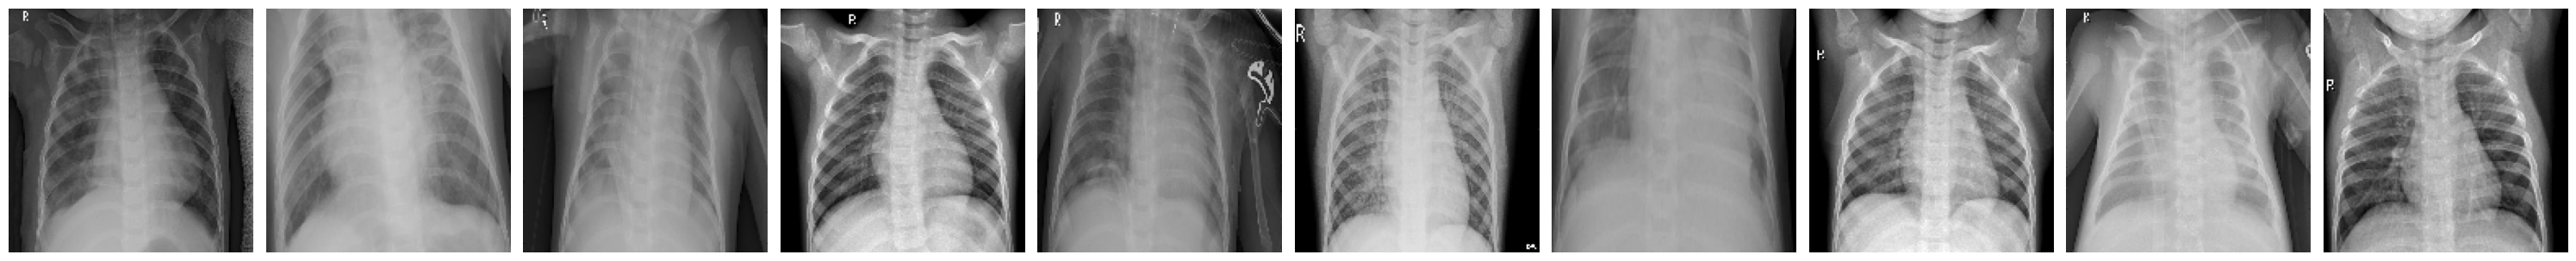

[1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0.
 1. 1. 1. 1. 0. 1. 1. 1.]


In [10]:
imgs, labels = next(train_gen)
plotImages(imgs)
print(labels)

1---> Pneumonia

0--->Normal Xray

# DATA AUGMENTATION

Data Augmentation is to create new data based on modifications to existing data.
**But why?**
1. To add more data samples to our training set, if we have a small image sample size of our dataset to begin with.
2. To reduct overfitting, we can augment the data to make it more varried, therefore making our trained model more versatile.


Some common data augmentation techniques are:
1. Horizontal & Vertical Shifting
2. Horizontal & Vertical flipping
3. Random Rotation
4. Random brightness
5. Random Zooming

Let us try these different augmentation techniques on a sample image

download the image https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTrqWUxvjvW1PfKP4HLmhEG4fN4x1qEbPD3qw&usqp=CAU using wget (save it as aug.jpg)

In [ ]:
#download the image
!wget -O 'aug.jpg' https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTrqWUxvjvW1PfKP4HLmhEG4fN4x1qEbPD3qw&usqp=CAU

--2021-11-22 18:27:53--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTrqWUxvjvW1PfKP4HLmhEG4fN4x1qEbPD3qw
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 172.217.193.100, 172.217.193.138, 172.217.193.102, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|172.217.193.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3069 (3.0K) [image/jpeg]
Saving to: ‘aug.jpg’

aug.jpg             100%[===================>]   3.00K  --.-KB/s    in 0s      

2021-11-22 18:27:54 (18.4 MB/s) - ‘aug.jpg’ saved [3069/3069]



In [13]:
from numpy import expand_dims
from tensorflow.keras.utils  import load_img
from tensorflow.keras.utils  import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

In [15]:
normal_example = os.listdir('/content/drive/MyDrive/chest_xray/train/NORMAL')[0]
normal_img = plt.imread(f'/content/drive/MyDrive/chest_xray/train/NORMAL/{normal_example}')

### 1. Horizontal and vertical Shift

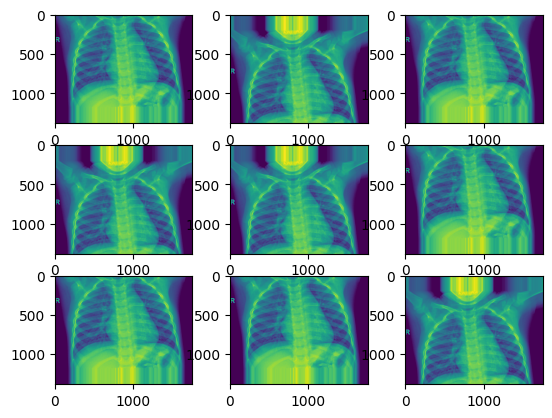

In [18]:
# horizontal shift image augmentation
# convert to numpy array
data = img_to_array(normal_img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=[-200,200])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

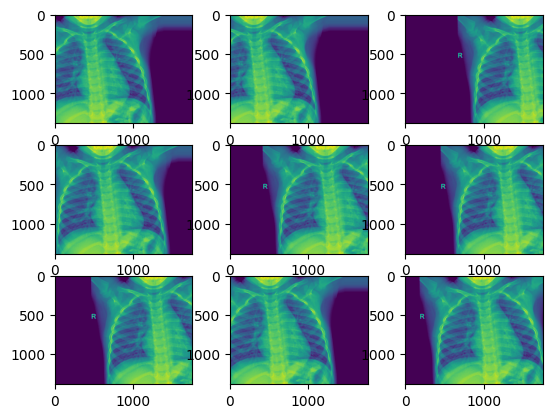

In [19]:
# vertical shift image augmentation
datagen = ImageDataGenerator(height_shift_range=0.5)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

### 2. Horizontal and vertical Flip


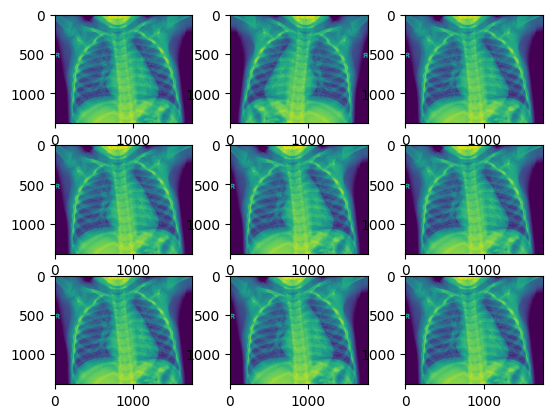

In [20]:
datagen = ImageDataGenerator(horizontal_flip=True)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

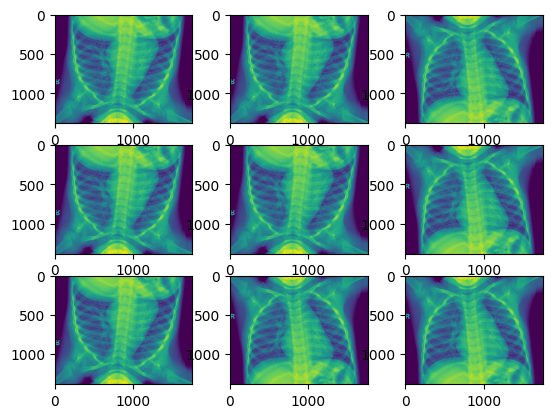

In [22]:
#code here
datagen = ImageDataGenerator(vertical_flip=True)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

### 3. Random Rotation

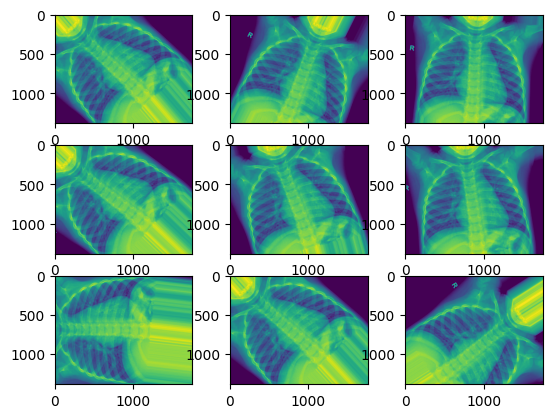

In [21]:
datagen = ImageDataGenerator(rotation_range=90)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

### 4. Random Brightness

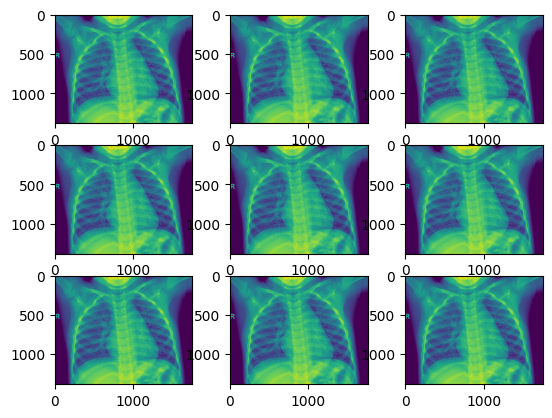

In [23]:
#code here
datagen = ImageDataGenerator(brightness_range=[0.1,1.0])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

### 5. Random Zoom

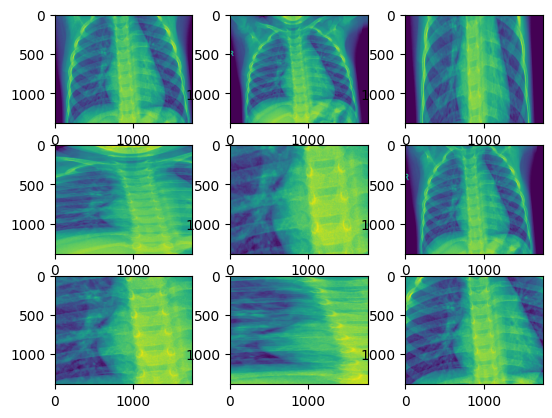

In [24]:
#code here
datagen = ImageDataGenerator(zoom_range=[0.1,1.0])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

#CREATING THE MODEL

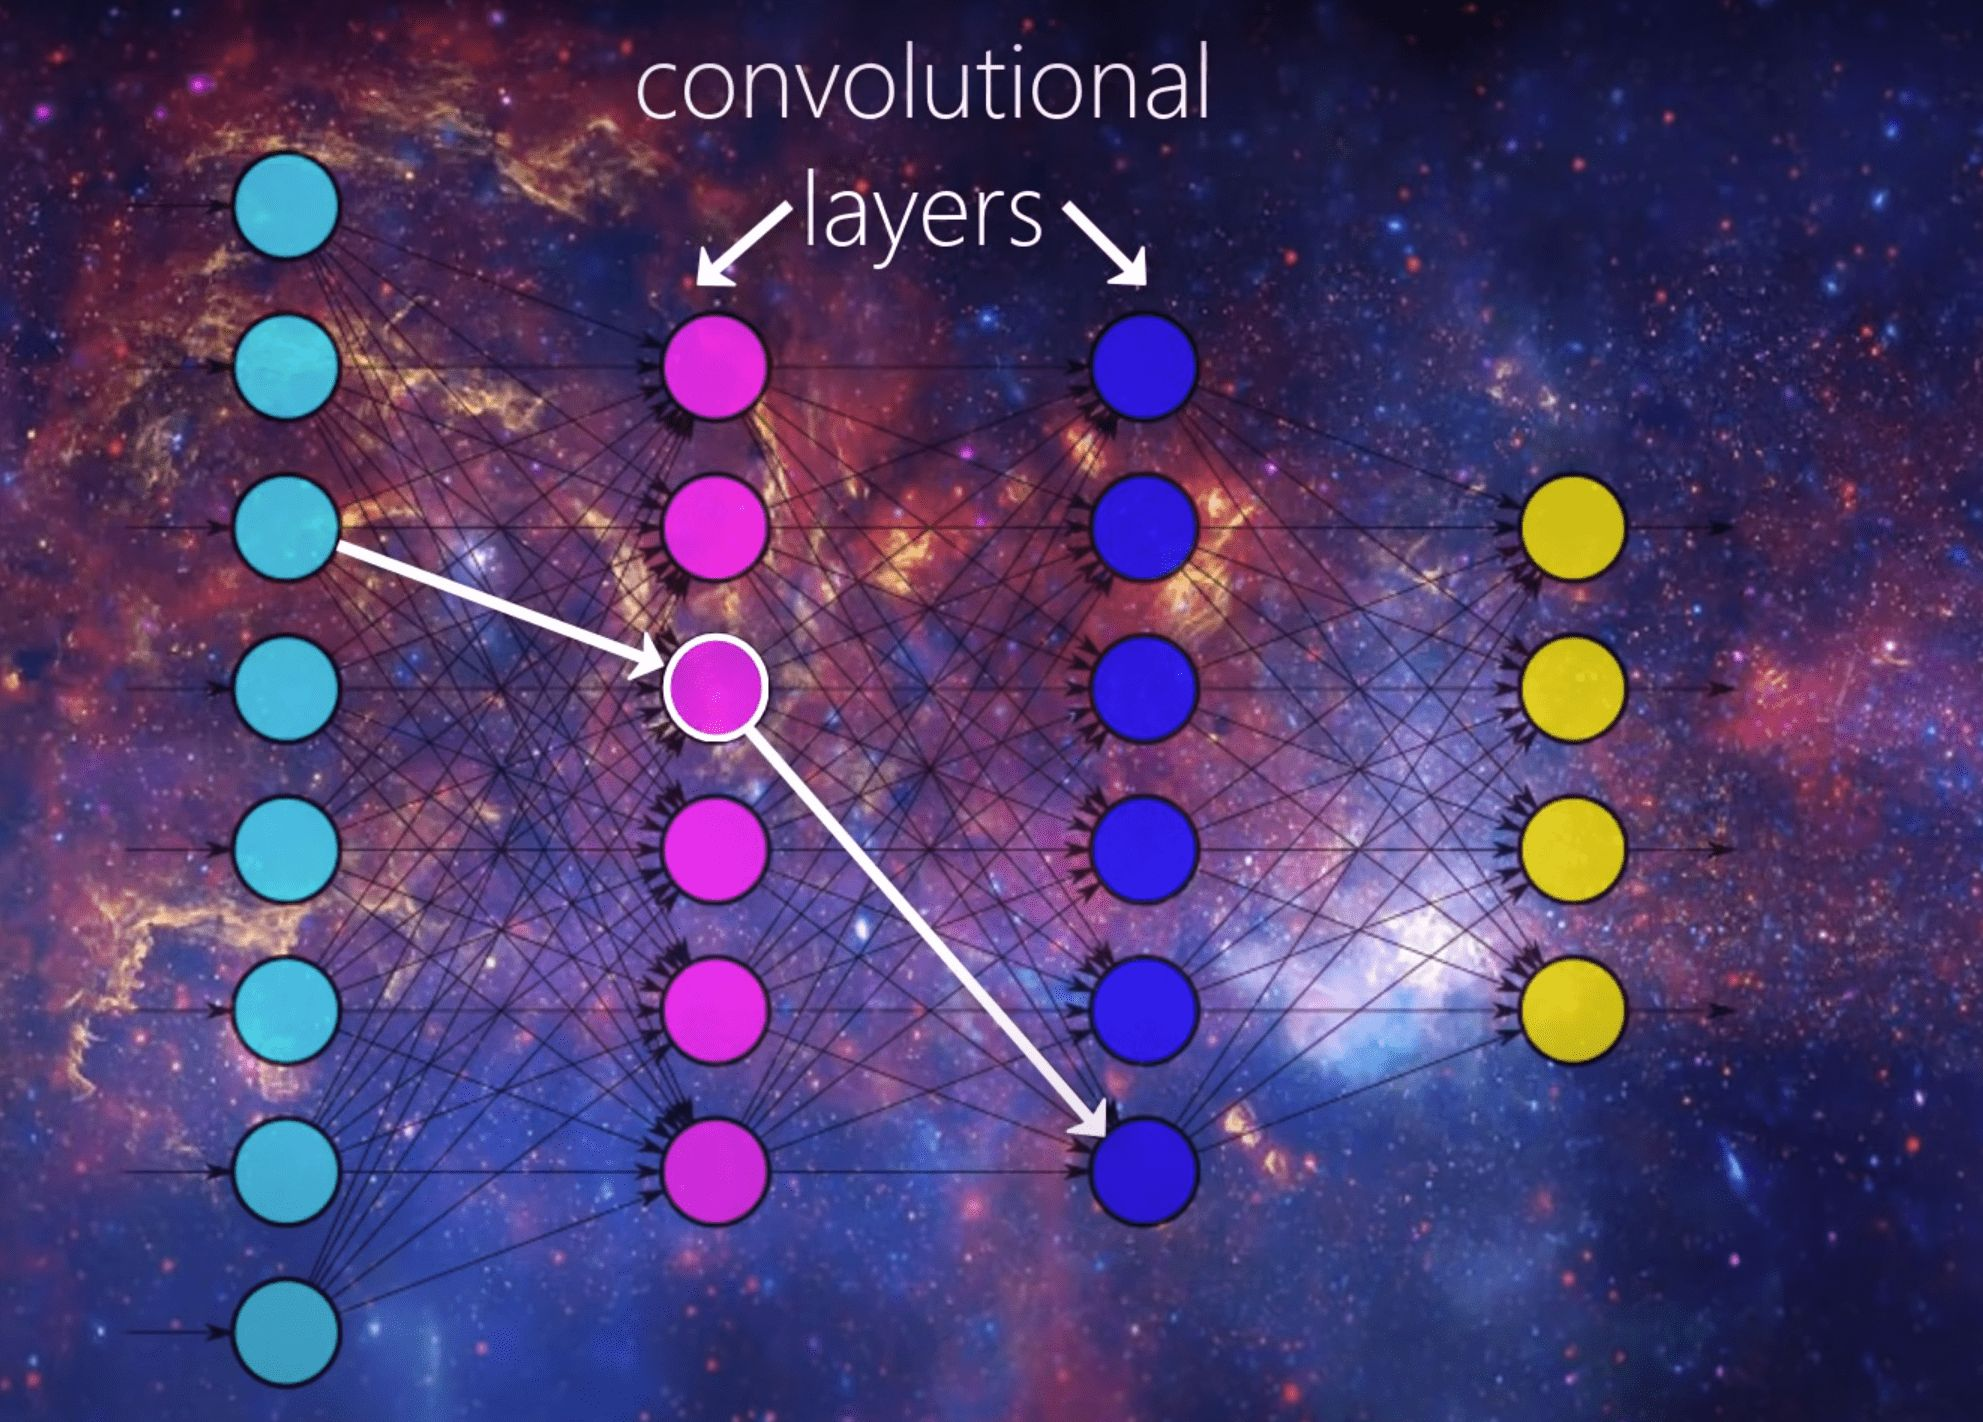

Convolutional Neural Networks(CNN's) is most usefull for image analysis due to its ability to pick out and detect patterns. This is possible due to its hidden layers known as ***Convolutional Layers***.

These Convolutional Layers recieve input from previous layer, perform matrix multiplication (i.e. Transformations) and output it to the next layer.
These are also reffered to as Convolutional Operations.


At each Convolutional Layer, ***filters*** or convolutional kernels are defined as matrices that slide over the input image and perform convolutional operations. This helps detect different features in the image, such as edges, corners, or textures. The output of the convolutional layer is a set of feature maps that highlight relevant features in the input image.



### Model Architecture

Here we will start by creating a short demo CNN Model layer-by-layer using the Keras Sequential API.

In [25]:
demo_model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(150,150,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=1, activation='softmax')
])


#### 1st Hidden layer

The first hidden layer is a standard convolutional layer, (**Conv2D**), with 32 filters each with a kernel size of 3x3. Remember each filter is dedicated to identifying some aspect of the image, say filter1 detects vertical boundaries of the ribcage, filter2 detects diagonal boundaries of the ribcage, and so on... The patterns that the filters are encoding will become complex over time as we go deeper into the convolutional layers of the network.






>**PADDING**:                
When a kernel reaches the edge of the image, it has to make some decision about what to do where there are no pixels present in the input image. For now, we are going forward with zero-padding the edges, achieved using **padding = 'same'**. Zero padding means providing a cushion of zeroes outside of the image (as seen in the image below). This helps to ensure the dimensionality of the input image isn’t reduced after the convolution operation.


>Let us take an example of input image matrix as 4x4 , and filter as 3x3. Then after performing 1 convolutional operation, the resultant matrix will be of 2x2.
This dimension of the output matrix is calculated using the formula (n-f+1) where,
*n=dim of input image
f=dim of feature matrix*.
Therfore to regain the original dimension of 4x4,  we add a zero padding to the 2x2 output matrix.

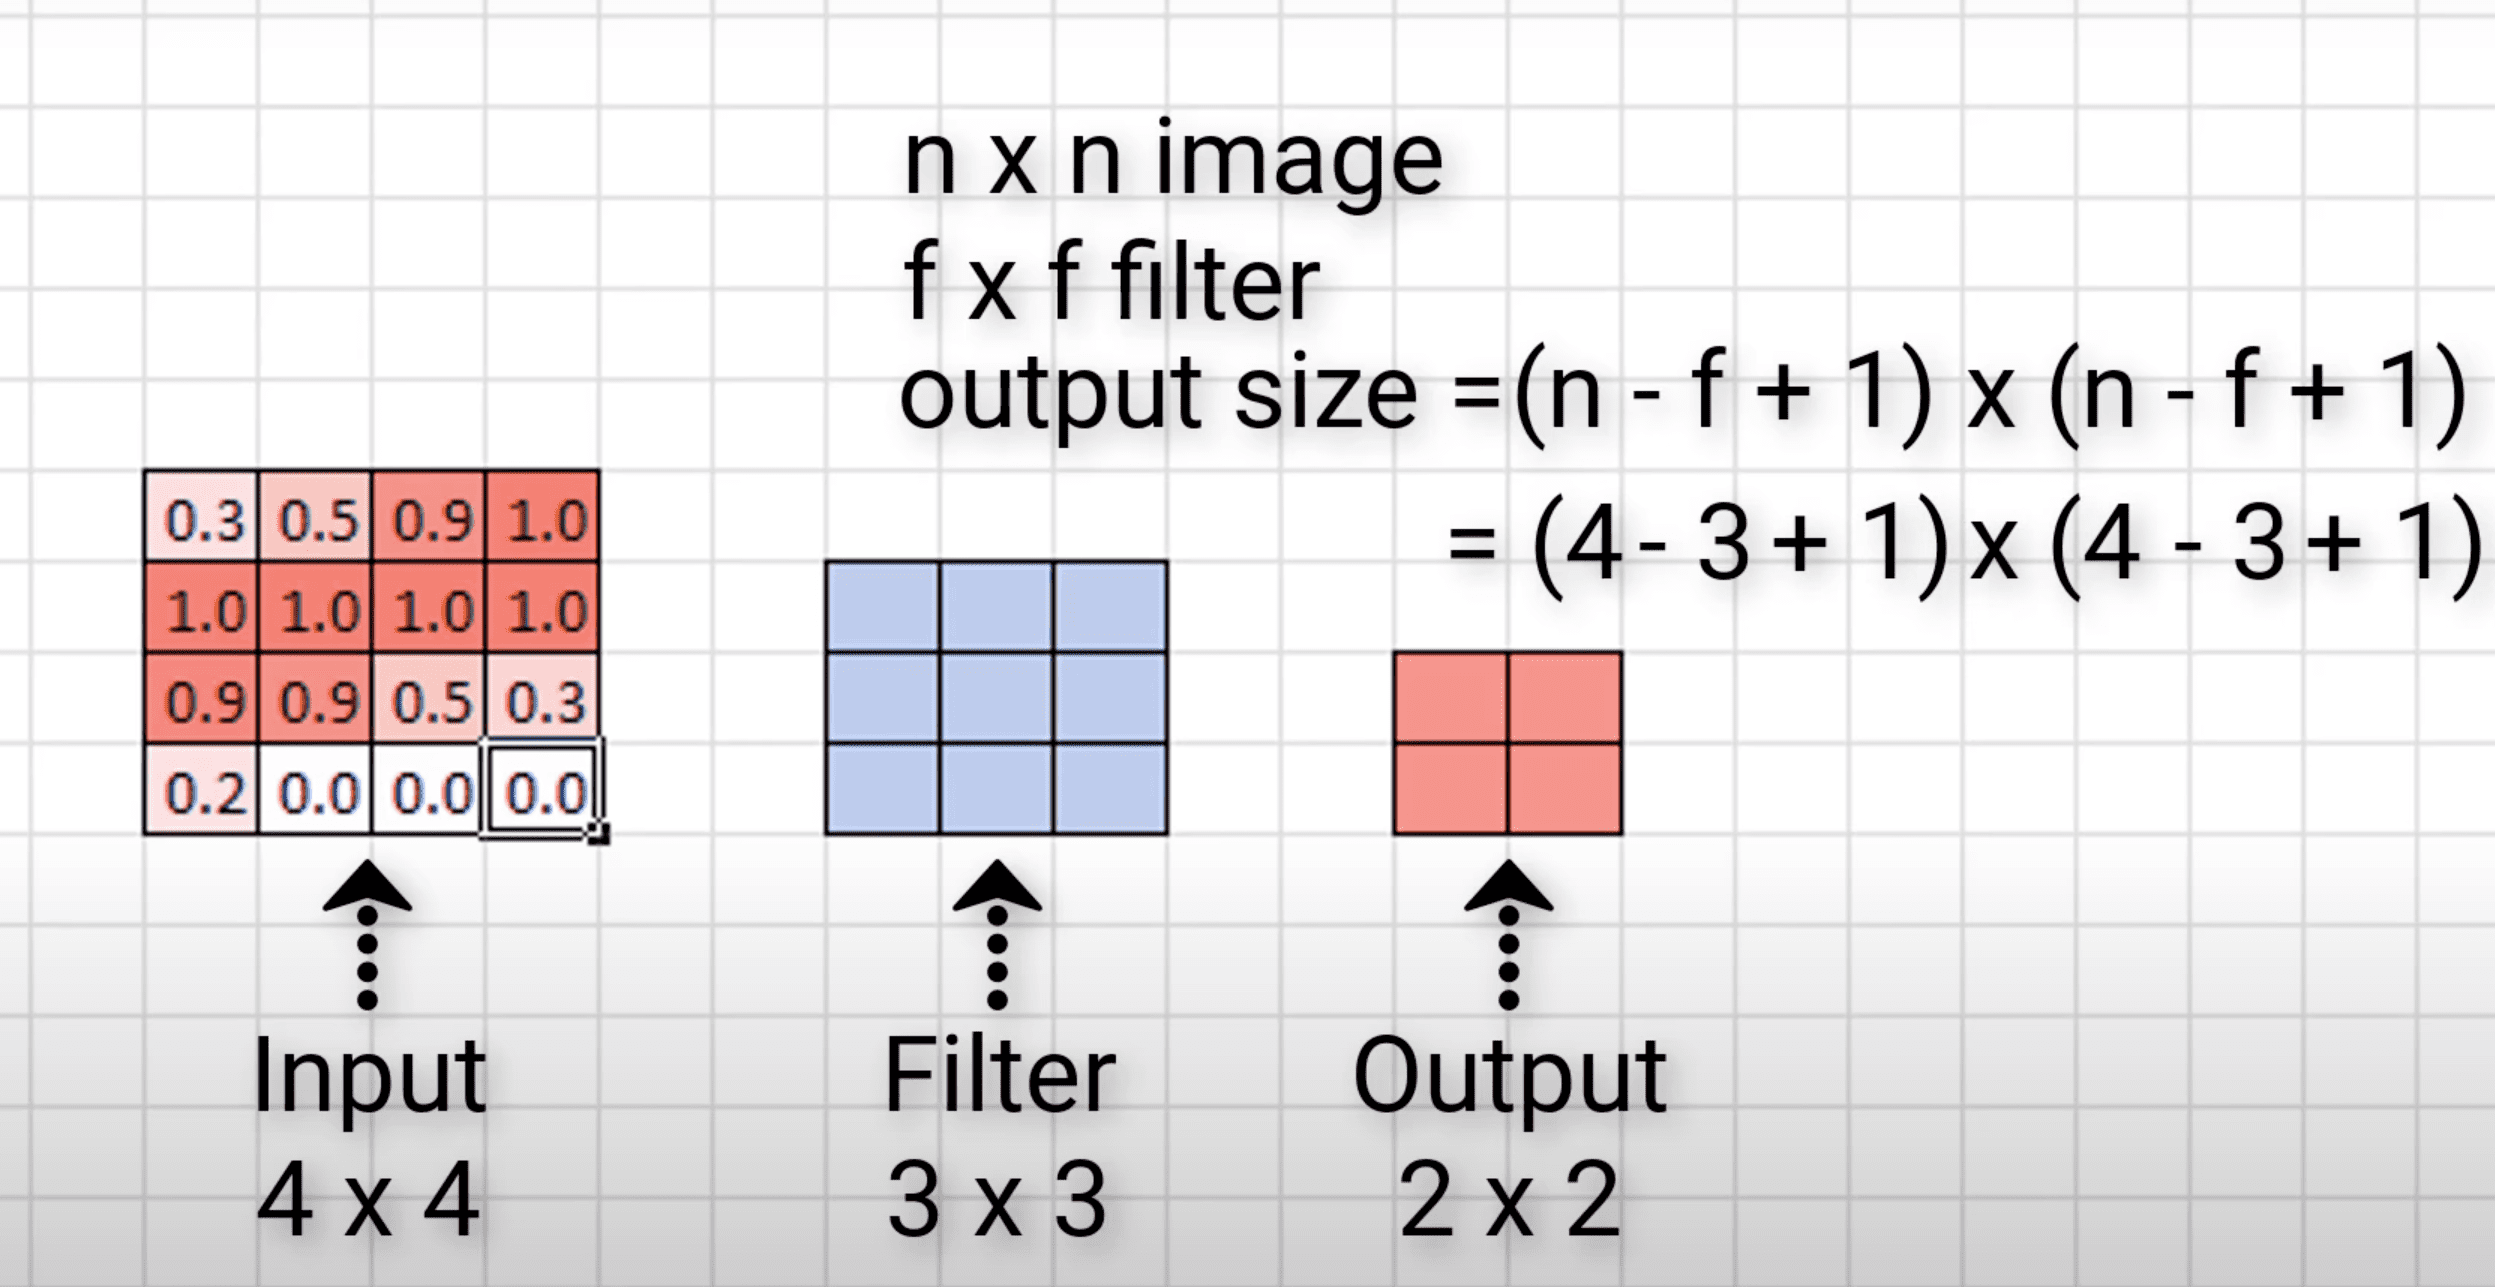


>**ACTIVATION**:     
An activation function takes in an input and transforms it into a desired range as an output. This is done to decide wether the neuron should be ***activated*** or not. Activation of a neuron is represented by 1,0

1 -> activated

0 -> not activated.



Some common examples of activation function are:
1. Sigmoid Function -
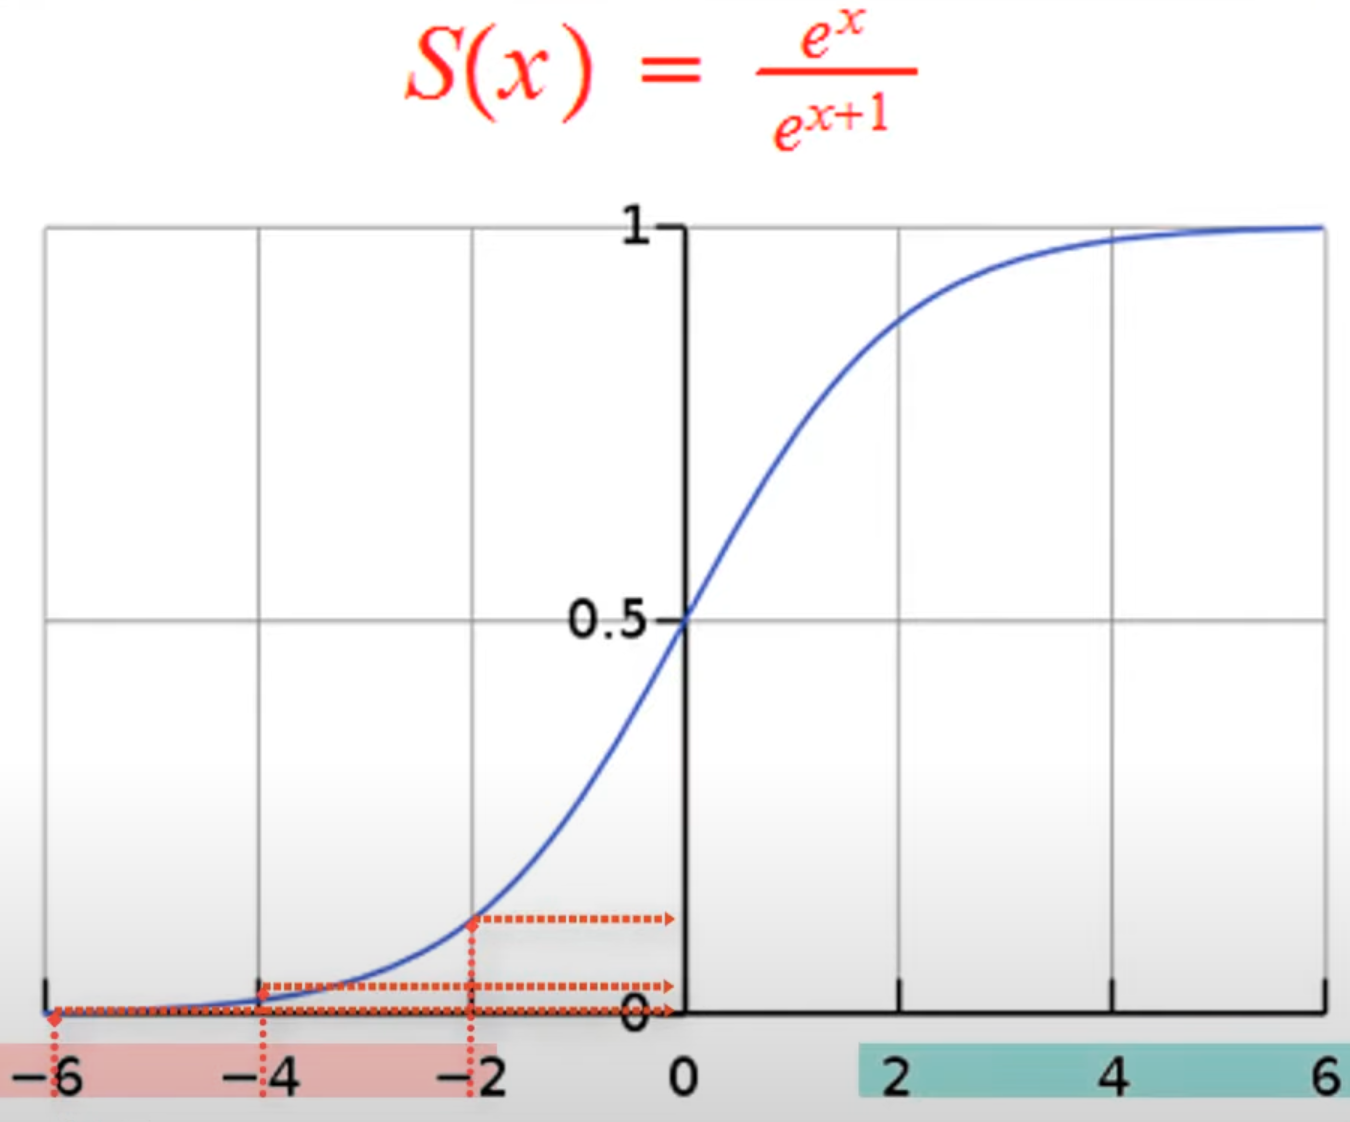

2. ReLU (Rectified Linear unit) Function-
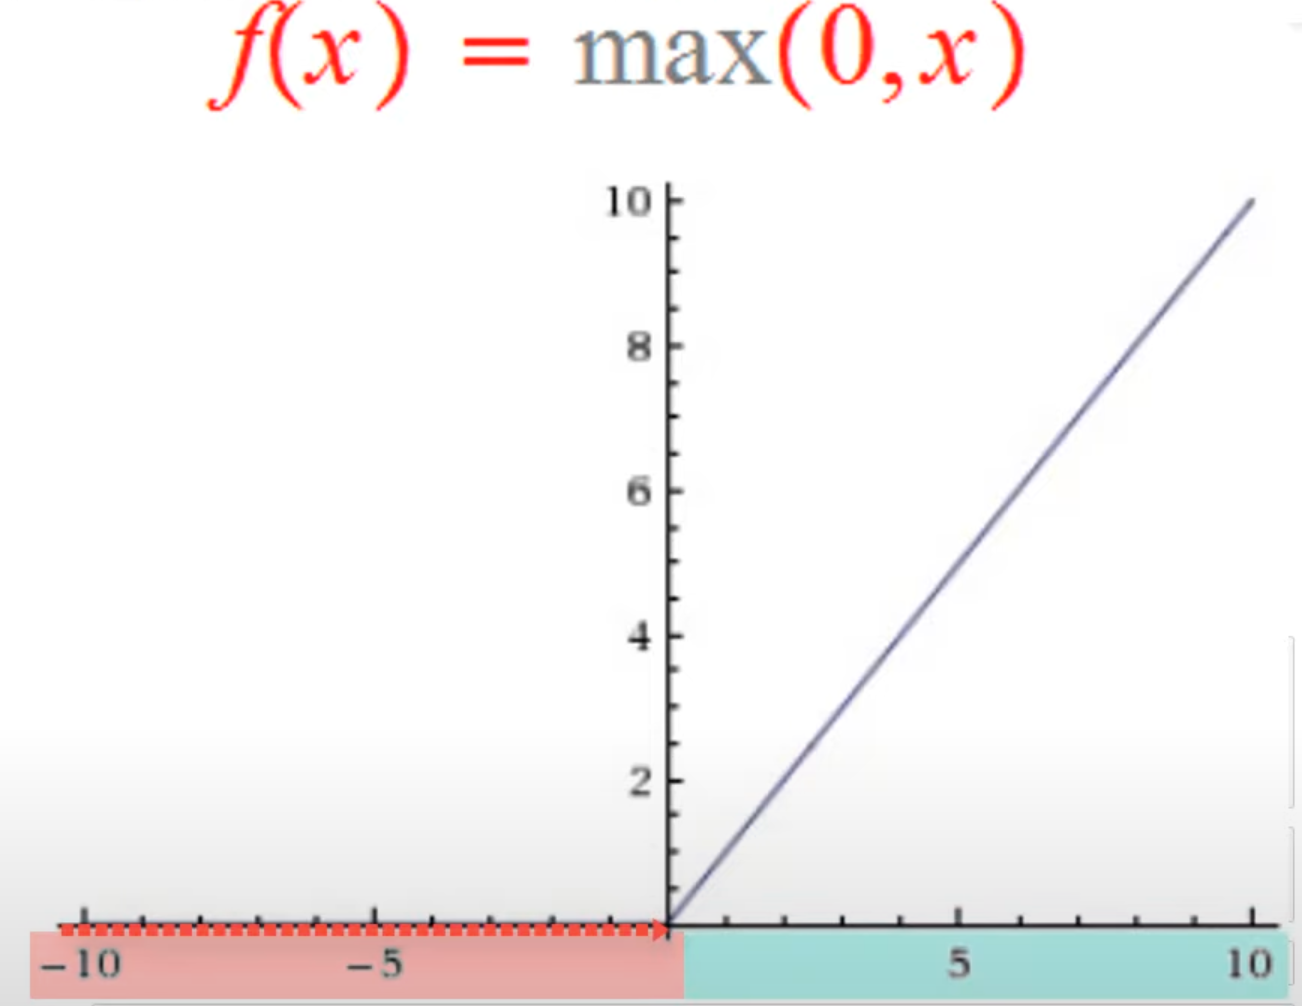

#### 2nd Hidden Layer



> **MAX POOLING**:

**Second hidden layer** is a max-pooling layer, (**MaxPool2D**), which is mainly for reducing the dimensionality of the data. The way it is doing that is by picking a window size ( pool_size = 2x2) from the filtered image (from convo/RELU layer) and then replace the 4 pixels in it with the highest value in that window. Next, it takes a stride of 2 steps to the right (or down or up) and replace those 4 pixels with the highest value. And so on until the entire image has been covered.
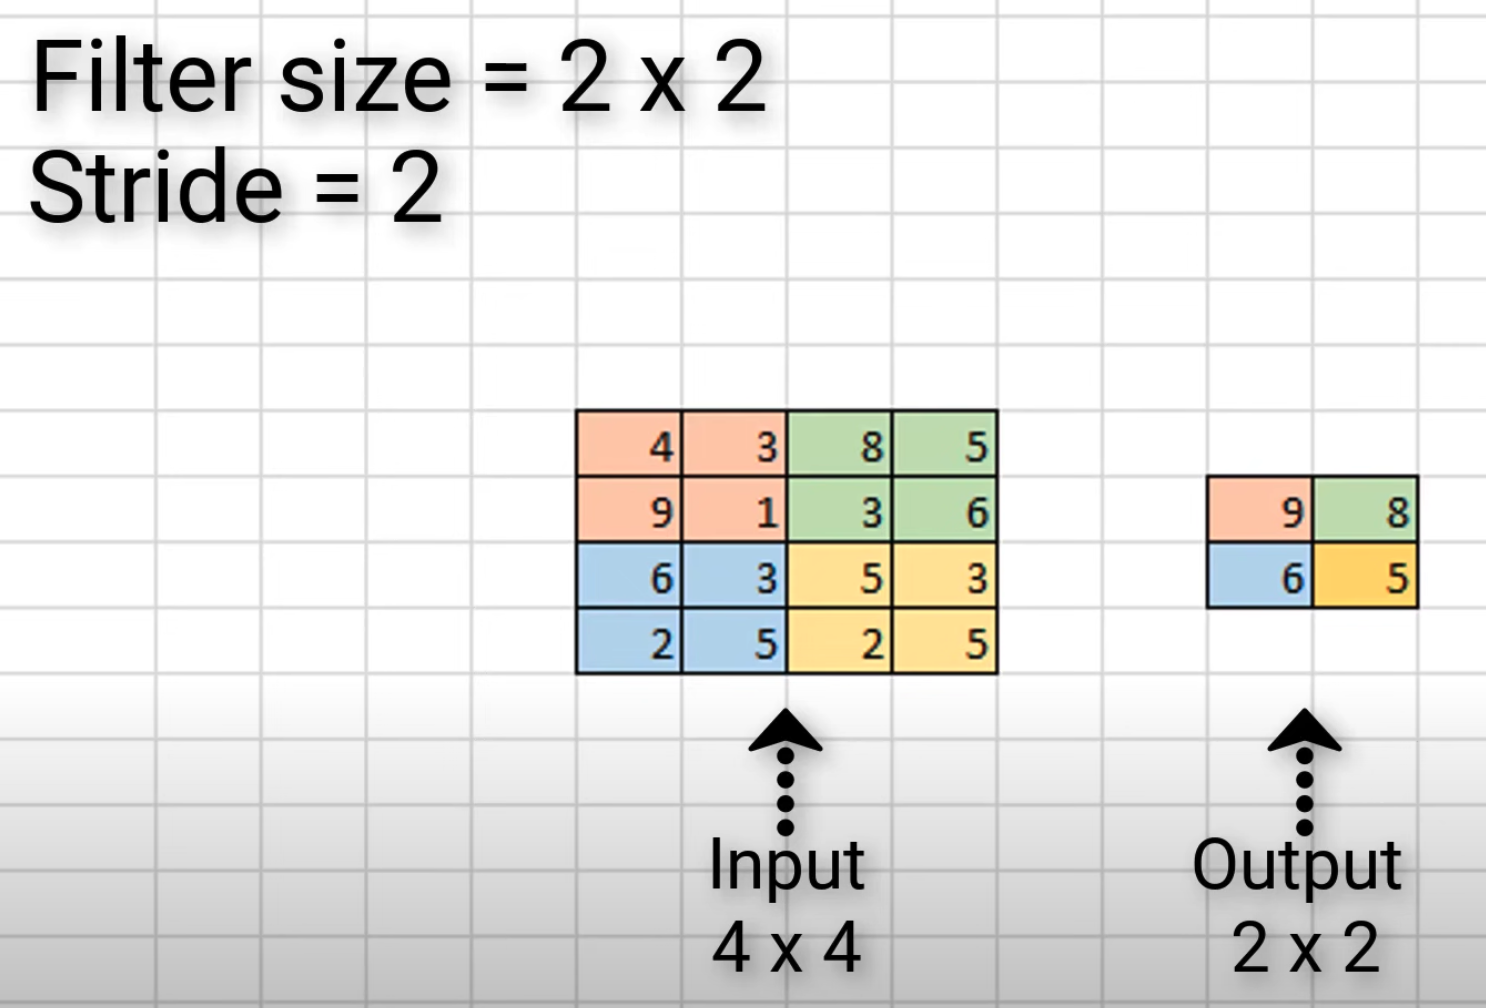


#### 3rd-4th Hidden Layers



> **The third and fourth hidden layers** are again Conv2Dand MaxPool2D, respectively.






***Note:*** *The second Conv2D layer has filters = 64 , double the number of filters in the first Conv2D layer (which has 32 filters). This increment in functions is a common practice as we go into the later layers of the network. The doubling of filter size is done so that the larger filter can capture more intricate and detailed features from the input data. And therefore allowing the the network to learn higher-level representations*



Finally, we
1. **Flatten Layer** -
convert a (NxN) matrix to (N^2,1) flattened matrix.
2. **Dense Layer** -
Also known as Fully Connected Layer where evert input unit is connected to every output unit via edges that have some assigned weights.
3. **Activation Function** -
 A Dense(Fully Connected layer) is often followed by a Non-Linear activation function (eg: softmax activation), as seen above.




###Model Performance

In [26]:
#summary on the model and each of its layer
demo_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense (Dense)               (None, 1)                 8

In [27]:
demo_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Traning Demo Model
hist = demo_model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size,
           verbose=2)

1. The steps_per_epoch is calculated based on your training data. For example, if the number of samples in our train set is 1000 and the batch size is 20, then the steps_per_epoch is calculated by dividing 1000/20 = 50.

2. *Steps_per_epoch is an integer and corresponds to the total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. It should typically be equal to ceil(num_samples / batch_size).*

###Model Optimization and Tuning

#### Hyperparameter Tuning

Some set of parameters that are used to control the behaviour of the model/algorithm and adjustable in order to obtain an improvised model with optimal performance is so-called Hyperparameters.
There are 2 common ways of tuning hyperparameters.
* Grid Search Cross-Validation
* Random Search Cross-validation

Some hyperparameters to tune are
1. Learning Rate
2. No of epochs
3. Batch size
4. Activation Function



>**Batch Normalization**
Is usefull as it standardizes the inputs to the subsequent layer of each mini-batch. Therefore it increase the speed of training a dataset

>**Dropout Layer**
The Dropout layer is a mask(sieve) that nullifies the contribution of some neurons towards the next layer and leaves unmodified all others. This is done by randomly deactivating some of the neurons. Dropout Layer is implimented to prevent overfitting of the model.

#### Creating a proper CNN Model

**Now create a CNN model**










In [ ]:
def cnn_model():
    model = Sequential([
    #Batch 1
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(150,150,3)),
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(150,150,3)),
    MaxPool2D(pool_size=(2, 2)),
    #Batch 2
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(75,75,3)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(75,75,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    #Batch 3
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(37,37,3)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(37,37,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    #Batch 4
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(18,18,3)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(18,18,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.2),
    #Batch 5
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(9,9,3)),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(9,9,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.2),
    Flatten(),
    #Fully Connected (FC-1)
    Dense(512),
    Dropout(rate=0.2),
    #FC-2
    Dense(128),
    Dropout(rate=0.2),
    #FC-3
    Dense(64),
    Dropout(rate=0.2),
    #Output activation probabilites
    Dense(1, activation='sigmoid'),
    ])



    return model

In [ ]:
cnn_model=cnn_model()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 32)       128       
 ormalization)                                          

>**Early Stopping**
If we train the model for extremely large number of epochs, hoping for a more precise and accurate model. This will result in model overfitting, and excessive time wasted in non-contributing epochs.
Early Stopping helps solve this problem, by halting the model training at the point beyond which the training epochs are dis-advantageous, and the model performance stops improving

We can specify the (monitor='accuracy')  to select the performance measure to monitor in order to end training. Patience is the delay in the training halt triggered, this is to avoid any premature halting.

#### Compile and fit the model

In [ ]:
#write the code here
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics="accuracy")
es = EarlyStopping(patience=15, monitor='accuracy', restore_best_weights=True)
hist= cnn_model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size,
           verbose=2,callbacks=[es])

Epoch 1/10
163/163 - 464s - loss: 0.1589 - accuracy: 0.9549 - 464s/epoch - 3s/step
Epoch 2/10
163/163 - 461s - loss: 0.1027 - accuracy: 0.9678 - 461s/epoch - 3s/step
Epoch 3/10
163/163 - 461s - loss: 0.0672 - accuracy: 0.9766 - 461s/epoch - 3s/step
Epoch 4/10
163/163 - 465s - loss: 0.0822 - accuracy: 0.9745 - 465s/epoch - 3s/step
Epoch 5/10
163/163 - 455s - loss: 0.0688 - accuracy: 0.9793 - 455s/epoch - 3s/step
Epoch 6/10
163/163 - 454s - loss: 0.1306 - accuracy: 0.9693 - 454s/epoch - 3s/step
Epoch 7/10
163/163 - 454s - loss: 0.1179 - accuracy: 0.9720 - 454s/epoch - 3s/step
Epoch 8/10
163/163 - 455s - loss: 0.0551 - accuracy: 0.9831 - 455s/epoch - 3s/step
Epoch 9/10
163/163 - 458s - loss: 0.0356 - accuracy: 0.9875 - 458s/epoch - 3s/step
Epoch 10/10
163/163 - 461s - loss: 0.0538 - accuracy: 0.9826 - 461s/epoch - 3s/step
